[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/James-Leslie/deep-collaborative-filtering/blob/master/movielens_skorch.ipynb)

In [ ]:
# !pip install tensorflow-gpu==2.0.0-beta1

In [1]:
%load_ext tensorboard

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, datetime
import warnings

from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

from sklearn.model_selection import train_test_split

%matplotlib inline

## Load ratings data

In [3]:
# path = 'https://raw.githubusercontent.com/James-Leslie/deep-collaborative-filtering/master/data/goodbooks-10k/'  # access from anywhere
path = 'data/goodbooks-10k/'  # if the files are local
train = pd.read_csv(path+'train.csv')
test = pd.read_csv(path+'test.csv')
df = pd.concat((train, test), ignore_index=True)

In [4]:
df.head()

,user_id,book_id,rating
0,26985,1,5
1,32332,1899,5
2,50054,3114,4
3,33313,2800,4
4,12666,1479,5


In [5]:
df.shape

(5976479, 3)

## Load pre-trained base model

In [8]:
from tensorflow.keras import backend as K

def stretch(x):
    return K.sigmoid(x) * (5 - 1) + 1

In [9]:
# item embedding path
item_input = Input(shape=[1], name="Item-Input")
item_embedding = Embedding(max_items+1, 25, name="Item-Embedding")(item_input)
item_vec = Flatten(name="Flatten-Items")(item_embedding)

# user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(max_users+1, 25, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

# concatenate features
conc = Concatenate()([item_vec, user_vec])

# add fully-connected-layers
fc1 = Dense(64, activation='relu')(conc)
d1 = Dropout(.5)(fc1)
fc2 = Dense(32, activation='relu')(d1)
d2 = Dropout(.25)(fc2)
out = Dense(1, activation=stretch)(d2)

# create model and compile it
model = Model([user_input, item_input], out)
model.compile('adam', 'mean_squared_error')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item-Input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
User-Input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
Item-Embedding (Embedding)      (None, 1, 25)        250000      Item-Input[0][0]                 
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 25)        1335600     User-Input[0][0]                 
______________________________________________________________________________________________

#### load pre-trained weights

In [10]:
model.load_weights("models/goodbooks.ckpt")

#### check its predictive accuracy on the ratings

In [11]:
model.evaluate([df.user_id, df.book_id], df.rating, batch_size=1024)

5976479/5976479 [==============================] - 28s 5us/sample - loss: 0.6437


0.6436596912644581

In [12]:
np.sqrt(0.6437)

0.8023091673413685

In [13]:
predictions = model.predict([df.user_id.head(10), df.book_id.head(10)])

[print(predictions[i], df.rating.iloc[i]) for i in range(0,10)]

[4.7471237] 5
[4.148156] 5
[3.863347] 4
[3.5951762] 4
[4.452484] 5
[3.645379] 3
[4.365432] 5
[3.7191439] 5
[4.4383307] 5
[4.740861] 4


[None, None, None, None, None, None, None, None, None, None]

## Create second model to predict genres
We will re-use the item embedding layer from the base model to learn a mapping between embeddings and genres

In [14]:
checkpoint_path = "models/goodbooks_genres.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)

# Create checkpoint callback
cp_callback = ModelCheckpoint(checkpoint_path,
                              save_weights_only=True,
                              verbose=1)

In [16]:
logs_base_dir = "logs"
logdir = logs_base_dir + '\\genre\\' + datetime.datetime.now().strftime("%Y%m%d")
os.makedirs(logdir, exist_ok=True)
%tensorboard --logdir {logdir}

Reusing TensorBoard on port 6006 (pid 7320), started 0:52:04 ago. (Use '!kill 7320' to kill it.)

In [17]:
tensorboard_callback = TensorBoard(logdir, histogram_freq=1, embeddings_freq=1)

In [18]:
# make new genre model
fc1 = Dense(16, activation='relu')(item_vec)
d1 = Dropout(.25)(fc1)
fc2 = Dense(8, activation='relu')(d1)
d2 = Dropout(.25)(fc2)
genre_out = Dense(10, activation='sigmoid')(d2)

# Create model and compile it
model2 = Model(item_input, genre_out)
# freeze the embedding layer
model2.layers[1].trainable = False
model2.compile(optimizer='adam', loss='binary_crossentropy' , metrics=['accuracy'])
model2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Item-Input (InputLayer)      [(None, 1)]               0         
_________________________________________________________________
Item-Embedding (Embedding)   (None, 1, 25)             250000    
_________________________________________________________________
Flatten-Items (Flatten)      (None, 25)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                416       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dropout_3 (Dropout)          (None, 8)                 0   

In [19]:
books = pd.read_csv(path+'books.csv')

In [20]:
books.head()

,book_id,original_title,language_code,adult,adult-fiction,adventure,book-club,contemporary,fantasy,fiction,mystery,romance,young-adult
0,0,The Hunger Games,eng,0,0,1,1,1,1,1,0,1,1
1,1,Harry Potter and the Philosopher's Stone,eng,0,0,1,0,1,1,1,1,0,1
2,2,Twilight,en-US,0,0,0,1,1,1,1,0,0,1
3,3,To Kill a Mockingbird,eng,1,1,0,1,1,0,1,1,0,1
4,4,The Great Gatsby,eng,1,1,0,1,0,0,1,0,1,1


W0712 15:16:02.097356  3600 deprecation.py:323] From C:\Users\JLeslie\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 7756 samples, validate on 1939 samples
Epoch 1/10
6656/7756 [========================>.....] - ETA: 0s - loss: 0.6772 - accuracy: 0.5679
Epoch 00001: saving model to models/goodbooks_genres.ckpt
7756/7756 [==============================] - 1s 102us/sample - loss: 0.6746 - accuracy: 0.5728 - val_loss: 0.6446 - val_accuracy: 0.6332
Epoch 2/10
6208/7756 [=======================>......] - ETA: 0s - loss: 0.6423 - accuracy: 0.6181
Epoch 00002: saving model to models/goodbooks_genres.ckpt
7756/7756 [==============================] - 0s 43us/sample - loss: 0.6404 - accuracy: 0.6207 - val_loss: 0.6222 - val_accuracy: 0.6531
Epoch 3/10
6592/7756 [========================>.....] - ETA: 0s - loss: 0.6279 - accuracy: 0.6301
Epoch 00003: saving model to models/goodbooks_genres.ckpt
7756/7756 [==============================] - 0s 41us/sample - loss: 0.6270 - accuracy: 0.6318 - val_loss: 0.6148 - val_accuracy: 0.6603
Epoch 4/10
6912/7756 [=========================>....] - ETA: 0s - loss: 0.6

Text(0, 0.5, 'Training Error')

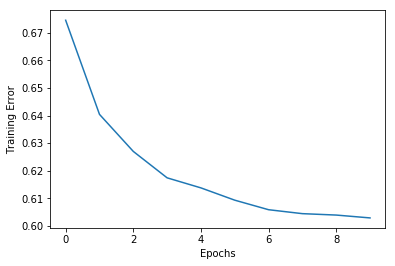

In [21]:
history = model2.fit(books.book_id, books.iloc[:,-10:], 
                     batch_size=64, 
                     epochs=10,
                     validation_split=.2,
                     callbacks=[cp_callback, tensorboard_callback])

plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Training Error")

In [22]:
model2.evaluate(books.book_id, books.iloc[:,-10:], batch_size=128)

9695/9695 [==============================] - 0s 17us/sample - loss: 0.5927 - accuracy: 0.6743


[0.5926818222406908, 0.6743064]

In [23]:
# check predictions of first 10 books
np.round(model2.predict(books.book_id.head(10)))

array([[1., 0., 0., 0., 1., 1., 1., 0., 1., 0.],
       [1., 0., 1., 0., 0., 1., 1., 0., 1., 0.],
       [1., 1., 0., 0., 1., 0., 1., 0., 1., 0.],
       [1., 0., 0., 1., 0., 0., 1., 0., 0., 0.],
       [1., 1., 0., 1., 1., 0., 1., 0., 0., 0.],
       [1., 1., 0., 1., 1., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
       [1., 1., 0., 1., 1., 0., 1., 0., 0., 0.],
       [1., 1., 0., 0., 1., 0., 1., 0., 1., 0.],
       [1., 0., 0., 1., 0., 0., 1., 0., 0., 0.]], dtype=float32)

## Check accuracy for only the romance tag

In [24]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

In [25]:
y_true = books.iloc[:,-10:]
y_score = pd.DataFrame(model2.predict(books.book_id), columns=y_true.columns)
y_pred = y_score.round().astype('int')

In [26]:
rom_true = y_true.romance
rom_pred = y_pred.romance

In [27]:
print(classification_report(rom_true, rom_pred))

              precision    recall  f1-score   support

           0       0.68      0.75      0.71      5444
           1       0.63      0.54      0.58      4251

   micro avg       0.66      0.66      0.66      9695
   macro avg       0.65      0.64      0.65      9695
weighted avg       0.65      0.66      0.65      9695



In [28]:
pd.DataFrame(confusion_matrix(rom_true, rom_pred))

,0,1
0,4095,1349
1,1968,2283


In [29]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(rom_true, y_score.iloc[:,-2])

In [30]:
prt_df = pd.DataFrame([thresholds, precision, recall]).T
prt_df.columns = ['threshold','precision','recall']
prt_df.head()

,threshold,precision,recall
0,0.155812,0.438519,1.000000
1,0.161854,0.438461,0.999765
2,0.165697,0.438506,0.999765
3,0.166372,0.438551,0.999765
4,0.168274,0.438596,0.999765


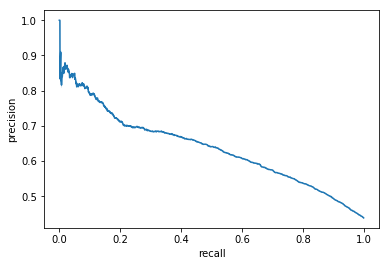

In [31]:
sns.lineplot(x=prt_df.recall,
             y=prt_df.precision)
plt.show()

### Global accuracy

In [32]:
(y_true == y_pred).astype('int').mean()

adult            0.681176
adult-fiction    0.591129
adventure        0.636720
book-club        0.714183
contemporary     0.634966
fantasy          0.628675
fiction          0.938319
mystery          0.634451
romance          0.657865
young-adult      0.625580
dtype: float64

In [33]:
from sklearn.metrics import accuracy_score, coverage_error
# how many perfectly classified rows
accuracy_score(y_true, y_pred)

0.04053635894791129

In [34]:
coverage_error(y_true, y_score)

7.664569365652398

In [35]:
print(classification_report(y_true, y_pred, target_names=y_true.columns))

               precision    recall  f1-score   support

        adult       0.68      1.00      0.81      6604
adult-fiction       0.57      0.68      0.62      4775
    adventure       0.56      0.19      0.28      3661
    book-club       0.68      0.68      0.68      4365
 contemporary       0.63      0.81      0.71      5287
      fantasy       0.63      0.38      0.47      4259
      fiction       0.94      1.00      0.97      9097
      mystery       0.57      0.16      0.25      3686
      romance       0.63      0.54      0.58      4251
  young-adult       0.00      0.00      0.00      3630

    micro avg       0.70      0.63      0.67     49615
    macro avg       0.59      0.54      0.54     49615
 weighted avg       0.64      0.63      0.61     49615
  samples avg       0.70      0.65      0.65     49615



C:\Users\JLeslie\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\JLeslie\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\JLeslie\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [36]:
(y_true == y_pred).astype('int').mean().mean()

0.6743063434760186

In [37]:
f1_score(y_true, y_pred, average='micro')

0.6651182522006576

### Precision and Recall

In [38]:
recall_score(y_true, y_pred, average='micro')

0.6320064496624005

In [39]:
precision_score(y_true, y_pred, average='micro')

0.7018914381645216